# SST anomalies
Plot the SST anomalies for the Global Ocean.    
Prepared to work with MODIS-Terra SST 4 µm nightime data, at 9 km resolution, download from [Ocean Color](https://oceancolor.gsfc.nasa.gov/).

In [1]:
import sys
sys.path.insert(0, '..')
import os
import glob
import numpy as np
from filament import filament
import datetime
import cmocean
import logging
import netCDF4
import calendar
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
from importlib import reload
reload(filament)

<module 'filament.filament' from '../filament/filament.py'>

## Logger

In [2]:
logger = logging.getLogger("SSTanom")
logger.setLevel(logging.INFO)
logging.info("Starting")

## Files and directories

In [3]:
year = 2006
sat = "TERRA"
sensor = "MODIS"
figdir = "/data/SST/Global/figures/Canary"
monthlydir = "/data/SST/Global/monthly/{}".format(year)
climdir = "/data/SST/Global/monthly_clim/"

## Plot preparation
### Projection

In [4]:
sstmonthfile = filament.get_monthly_filename(sat, sensor, year, 1)
SSTmonth = filament.SST()
SSTmonth.read_from_oceancolorL3(os.path.join(monthlydir, sstmonthfile))

In [5]:
m = Basemap(projection='ortho',lon_0=-52.,lat_0=10,resolution='h')
llon, llat = np.meshgrid(SSTmonth.lon, SSTmonth.lat)
lonp, latp = m(llon, llat)
lonp[lonp==lonp.max()] = np.nan
latp[latp==latp.max()] = np.nan

### Plotting function

In [6]:
def make_monthly_subplot(m, lon, lat, SSTanom, month, NN=1, fgcolor="k", figtitle=None):
    
    if figtitle is not None:
        plt.title(figtitle, fontsize=18, color=fgcolor)
    m.drawcoastlines(linewidth=.2)
    pcm = m.pcolormesh(lon[::NN], lat[::NN], SSTanom[::NN],
                       cmap=plt.cm.RdBu_r, vmin=-2.5, vmax=2.5, zorder=2)
    m.fillcontinents(color='grey', zorder=3)
    #plt.colorbar(extend="both", shrink=.7)
    #m.warpimage("world.topo.bathy.200403.3x5400x2700.jpg", zorder=2)
    m.drawcoastlines(linewidth=.2, zorder=4, color="grey")
    #plt.savefig(os.path.join(figdir, "SST_anom_test"), dpi=300, bbox_inches="tight")
    # plt.show()
    #plt.close()
    return pcm

In [7]:
def make_empty_subplot(m, fgcolor="k", figtitle=None):
    
    if figtitle is not None:
        plt.title(figtitle, fontsize=18, color=fgcolor)
    m.drawcoastlines(linewidth=.2)
    m.fillcontinents(color='grey', zorder=3)
    #plt.colorbar(extend="both", shrink=.7)
    #m.warpimage("world.topo.bathy.200403.3x5400x2700.jpg", zorder=2)
    m.drawcoastlines(linewidth=.2, zorder=4, color="grey")

In [8]:
fig = plt.figure(figsize=(12, 12), facecolor=bgcolor)
ax = plt.subplot(111)
make_empty_subplot(m)
plt.savefig(os.path.join(figdir, "SSTanomalies_empty"), 
                    facecolor=fig.get_facecolor(),
                    dpi=300, bbox_inches="tight")
plt.close()

NameError: name 'bgcolor' is not defined

## Figure with the 12 months together

In [8]:
plt.close("all")
bgcolor = "black"
fgcolor = "white"

In [13]:
fig = plt.figure(figsize=(13, 10), facecolor=bgcolor)

for imonth in range(7, 9):
    if imonth == 1:
        yearstart = 2001
    else: 
        yearstart = 2000
    if imonth <= 5:
        yearend = 2020
    else:
        yearend = 2019
        
        
    sstclimfile = filament.get_monthly_clim_filename(sat, sensor, yearstart, yearend, imonth, res="9km")
    sstmonthfile = filament.get_monthly_filename(sat, sensor, year, imonth, res="9km")
    sstclimfile = os.path.join(climdir, sstclimfile)
    sstmonthfile = os.path.join(monthlydir, sstmonthfile)
    
    if os.path.exists(sstclimfile) & os.path.exists(sstmonthfile):
        logger.info("Working on month {}/12".format(imonth))
        # Read data (lon, lat and SST)
        SSTmonth = filament.SST()
        SSTmonth.read_from_oceancolorL3(sstmonthfile)
        SSTclim = filament.SST()
        SSTclim.read_from_oceancolorL3(sstclimfile)
    
        # Compute anomalies
        SSTanom = SSTmonth.field - SSTclim.field
        
        # Individual figures
        fig = plt.figure(figsize=(12, 12), facecolor=bgcolor)
        ax = plt.subplot(111)
        pcm = make_monthly_subplot(m, lonp, latp, SSTanom, imonth+1, NN=1, fgcolor=fgcolor)


        plt.savefig(os.path.join(figdir, "SSTanomalies_{}_{}".format(year, str(imonth).zfill(2))), 
                    facecolor=fig.get_facecolor(),
                    dpi=300, bbox_inches="tight")
        #plt.show()
        plt.close()

        """
        # Global figure
        ax = plt.subplot(3, 4, imonth)
        pcm = make_monthly_subplot(m, lonp, latp, SSTanom, imonth, NN=10, 
                                   fgcolor=fgcolor, figtitle=calendar.month_name[imonth])
        

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
normanom = mpl.colors.Normalize(vmin=-2.5, vmax=2.5)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=plt.cm.RdBu_r,
                                norm=normanom, orientation='vertical', 
                                extend="both")

cb1.set_label("$^{\circ}$C", rotation=0, ha="left", fontsize=18, 
              color=fgcolor, fontweight="bold")

cb1.ax.tick_params(axis='y', colors=fgcolor)


cb1_ytl = cb1.ax.get_yticklabels()
cb1.ax.set_yticklabels(cb1_ytl, color=fgcolor, 
                       fontweight="bold", fontsize=16)


fig.suptitle('Sea surface temperature anomalies $-$ {}'.format(year), 
             fontsize=24, color=fgcolor) 
plt.savefig(os.path.join(figdir, "SSTanomalies{}_test".format(year)), 
            facecolor=fig.get_facecolor(),
            dpi=300, bbox_inches="tight")
#plt.show()
plt.close()
"""

INFO:SSTanom:Working on month 7/12
INFO:SSTanom:Working on month 8/12


### Plot the colorbar alone

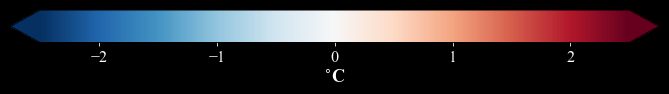

In [24]:
# Make a figure and axes with dimensions as desired.
fig = plt.figure(figsize=(10, 3), facecolor=bgcolor)
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cmap = mpl.cm.RdBu_r
normanom = mpl.colors.Normalize(vmin=-2.5, vmax=2.5)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=normanom,
                                orientation='horizontal', extend="both")

cb1.set_label("$^{\circ}$C", fontsize=18, color=fgcolor, fontweight="bold")

cb1.ax.tick_params(axis='x', colors=fgcolor)
cb1_xtl = cb1.ax.get_xticklabels()
cb1.ax.set_xticklabels(cb1_xtl, color=fgcolor, 
                       fontsize=16)

plt.savefig(os.path.join(figdir, "sst_colorbar.png"), dpi=300, bbox_inches="tight",
            facecolor=fig.get_facecolor())
plt.show()

## Regional

In [9]:
coordinates = (-20, -8., 25., 33.)
coordinates2 = (coordinates[0] - 0.5, coordinates[1] + 0.5, coordinates[2] - 0.5, coordinates[3] + 0.5)
m2 = Basemap(projection='merc', llcrnrlon=coordinates[0], llcrnrlat=coordinates[2],
            urcrnrlon=coordinates[1], urcrnrlat=coordinates[3],
            resolution='f')
sstmonthfile = filament.get_monthly_filename(sat, sensor, year, 1)
SSTmonth = filament.SST()
SSTmonth.read_from_oceancolorL3(os.path.join(monthlydir, sstmonthfile), domain=coordinates2)
llon, llat = np.meshgrid(SSTmonth.lon, SSTmonth.lat)
lonp, latp = m2(llon, llat)
lonp[lonp==lonp.max()] = np.nan
latp[latp==latp.max()] = np.nan

In [10]:
plt.close("all")
bgcolor = "black"
fgcolor = "white"

for year in range(2000, 2015):
    logger.info("Working on year {}".format(year))
    monthlydir = "/data/SST/Global/monthly/{}".format(year)

    fig = plt.figure(figsize=(12, 10), facecolor=bgcolor)

    for imonth in range(1, 13):
        if imonth == 1:
            yearstart = 2001
        else: 
            yearstart = 2000
        if imonth <= 5:
            yearend = 2020
        else:
            yearend = 2019


        sstclimfile = filament.get_monthly_clim_filename(sat, sensor, yearstart, yearend, imonth, res="9km")
        sstmonthfile = filament.get_monthly_filename(sat, sensor, year, imonth, res="9km")
        sstclimfile = os.path.join(climdir, sstclimfile)
        sstmonthfile = os.path.join(monthlydir, sstmonthfile)

        if os.path.exists(sstclimfile) & os.path.exists(sstmonthfile):
            logger.info("Working on month {}/12".format(imonth))
            # Read data (lon, lat and SST)
            SSTmonth = filament.SST()
            SSTmonth.read_from_oceancolorL3(sstmonthfile, domain=coordinates2)
            SSTclim = filament.SST()
            SSTclim.read_from_oceancolorL3(sstclimfile, domain=coordinates2)

            # Compute anomalies
            SSTanom = SSTmonth.field - SSTclim.field

            # Individual figure

            fig = plt.figure(figsize=(12, 12), facecolor=bgcolor)
            ax = plt.subplot(111)
            pcm = make_monthly_subplot(m2, lonp, latp, SSTanom, imonth+1, NN=1, fgcolor=fgcolor)


            plt.savefig(os.path.join(figdir, "Canary_SSTanomalies_{}_{}".format(year, str(imonth).zfill(2))), 
                        facecolor=fig.get_facecolor(),
                        dpi=300, bbox_inches="tight")
            #plt.show()
            plt.close()
        else:
            logger.warning("Files not found")


    """
            # Global figure
            ax = plt.subplot(3, 4, imonth)
            pcm = make_monthly_subplot(m2, lonp, latp, SSTanom, imonth, NN=1, 
                                       fgcolor=fgcolor, figtitle=calendar.month_name[imonth])


    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
    normanom = mpl.colors.Normalize(vmin=-2.5, vmax=2.5)
    cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=plt.cm.RdBu_r,
                                    norm=normanom, orientation='vertical', 
                                    extend="both")

    cb1.set_label("$^{\circ}$C", rotation=0, ha="left", fontsize=18, 
                  color=fgcolor, fontweight="bold")

    cb1.ax.tick_params(axis='y', colors=fgcolor)


    cb1_ytl = cb1.ax.get_yticklabels()
    cb1.ax.set_yticklabels(cb1_ytl, color=fgcolor, 
                           fontweight="bold", fontsize=16)


    fig.suptitle('Sea surface temperature anomalies $-$ {}'.format(year), 
                 fontsize=24, color=fgcolor) 
    plt.savefig(os.path.join(figdir, "Canary_SSTanomalies{}_".format(year)), 
                facecolor=fig.get_facecolor(),
                dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    """

INFO:SSTanom:Working on year 2000
INFO:SSTanom:Working on month 2/12
INFO:SSTanom:Working on month 3/12
INFO:SSTanom:Working on month 4/12
INFO:SSTanom:Working on month 5/12
INFO:SSTanom:Working on month 6/12
INFO:SSTanom:Working on month 7/12
INFO:SSTanom:Working on month 8/12
INFO:SSTanom:Working on month 9/12
INFO:SSTanom:Working on month 10/12
INFO:SSTanom:Working on month 11/12
INFO:SSTanom:Working on month 12/12
INFO:SSTanom:Working on year 2001
INFO:SSTanom:Working on month 1/12
INFO:SSTanom:Working on month 2/12
INFO:SSTanom:Working on month 3/12
INFO:SSTanom:Working on month 4/12
INFO:SSTanom:Working on month 5/12
INFO:SSTanom:Working on month 6/12
INFO:SSTanom:Working on month 7/12
INFO:SSTanom:Working on month 8/12
INFO:SSTanom:Working on month 9/12
INFO:SSTanom:Working on month 10/12
INFO:SSTanom:Working on month 11/12
INFO:SSTanom:Working on month 12/12
INFO:SSTanom:Working on year 2002
INFO:SSTanom:Working on month 1/12
INFO:SSTanom:Working on month 2/12
INFO:SSTanom:Work